In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Image_Classification

/content/drive/MyDrive/Image_Classification


# Make Dataset Directory

In [ ]:
import os
from make_dataset_dir import Make_Dataset_Dir

In [ ]:
mk = Make_Dataset_Dir()
mk.run()

총 소요시간: 0.01192초
---------------------------------
train의 Japan 이미지: 7장
train의 Taiwan 이미지: 7장
train의 Vietnam 이미지: 7장
train의 Philippines 이미지: 7장
train의 Thailand 이미지: 7장
valid의 Japan 이미지: 3장
valid의 Taiwan 이미지: 3장
valid의 Vietnam 이미지: 3장
valid의 Philippines 이미지: 3장
valid의 Thailand 이미지: 3장


# Dataloader
---
* Label: {'Japan':0, 'Taiwan':1, 'Vietnam':2, 'Philippines':3, 'Thailand':4}

In [ ]:
from custom_dataset import CustomDataset,Test_Dataset
from torch.utils.data import Dataset, DataLoader

In [ ]:
root_path = '/content/drive/MyDrive/Image_Classification/' #Change to your root_path
test_path = './Korea' #Change to your test directory path

### Pytorch 데이터 클래스 생성
train_class = CustomDataset(root_path=root_path, mode='train')
valid_class = CustomDataset(root_path=root_path, mode='valid')
test_class = Test_Dataset(test_path = test_path)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=1, shuffle=False, num_workers=0)

## 시각화

In [ ]:
import torch
import matplotlib.pyplot as plt

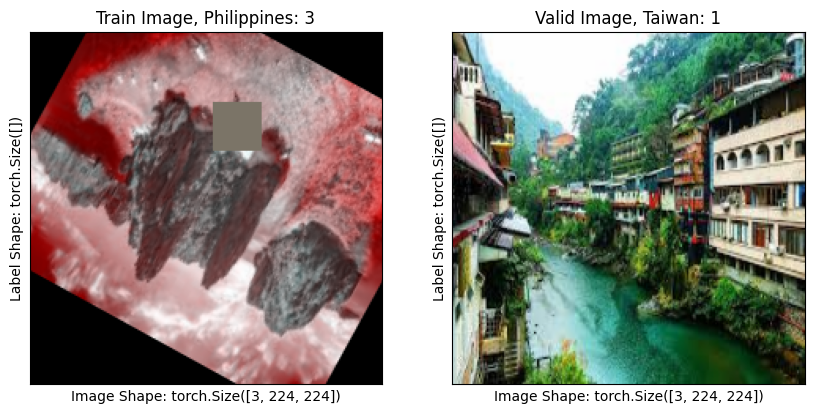

In [ ]:
class_names = ['Japan','Taiwan','Vietnam','Philippines','Thailand']

train_img,train_label = train_class[7]
valid_img,valid_label = valid_class[7]

plt.figure(figsize=(10,5))

for idx,(img,label) in enumerate(zip([train_img,valid_img],[train_label,valid_label])):
  t_img = img.permute(1,2,0).numpy()
  mean=(0.485, 0.456, 0.406)
  std=(0.229, 0.224, 0.225)
  t_img = (((t_img * std)+mean)*255).astype(int)

  plt.subplot(1,2,idx+1)
  if idx==0:
    plt.title(f'Train Image, {class_names[label]}: {label}')
  else:
    plt.title(f'Valid Image, {class_names[label]}: {label}')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f'Image Shape: {img.shape}')
  plt.ylabel(f'Label Shape: {torch.tensor(label).shape}') # 정수이기에 0차원

  plt.imshow(t_img)

plt.show()

# Fine-tuning ResNet50

In [ ]:
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

## 모델 불러오기

In [ ]:
from torchvision import models #모델 라이브러리 함수

resnet_50 = models.resnet50(pretrained=True).to(device) #선행학습 여부

import torch.nn as nn #파이토치 뉴럴네트워크 layer 라이브러리
resnet_50.fc = nn.Linear(resnet_50.fc.in_features,5).to(device)

## 모델 학습

In [ ]:
import copy
from torchvision import models #모델 라이브러리 함수

resnet_50 = models.resnet50(pretrained=True).to(device) #선행학습 여부

import torch.nn as nn #파이토치 뉴럴네트워크 layer 라이브러리
resnet_50.fc = nn.Linear(resnet_50.fc.in_features,5).to(device)


#하이퍼 파라미터
batch_size = 8
lr = 0.0001
epochs = 100
patience = 20
criterion = nn.CrossEntropyLoss().to(device) #cost function
optimizer = torch.optim.Adam(resnet_50.parameters(), lr=lr, weight_decay=1e-8)

train_acc_list = []
train_loss_list = []

valid_acc_list = []
valid_loss_list = []
best_val_acc = 0.0
epochs_no_improve = 0


for epoch in range(1, epochs+1) :
    running_loss = 0.0
    valid_running_loss = 0.0

    total = 0
    correct = 0

    train_acc = 0
    valid_acc = 0

    ''' Train  '''
    resnet_50.train()
    for i, (train_img, train_label) in enumerate(train_loader) :
        # gpu에 할당
        train_img = train_img.to(device)
        train_label = train_label.to(device)
        optimizer.zero_grad(set_to_none = True) # 계산했던 가중치 초기화

        output = resnet_50(train_img) #모델에 입력
        loss = criterion(output, train_label) #loss
        loss.backward() #loss로부터 역전파 : 미분 구하기
        optimizer.step() #학습

        # loss $ acc
        running_loss += loss.item()
        _, predictions = torch.max(output.data, dim=1)

        total += train_label.size(0)
        correct += (predictions == train_label).sum().item()
        train_acc += 100*(correct/total)

    running_loss = round(running_loss/(i+1),3) #소수점 반올림
    print(f'Trainset {epoch}/{epochs} Loss: {running_loss}, Accuracy: {round(train_acc/(i+1),3)}%')
    train_acc_list.append(train_acc/(i+1))
    train_loss_list.append(running_loss)

    ''' Valid '''
    resnet_50.eval()
    for i, (valid_img, valid_label) in enumerate(valid_loader):
        # gpu에 할당
        valid_img = valid_img.to(device)
        valid_label = valid_label.to(device)
        with torch.no_grad():
          output = resnet_50(valid_img) #모델에 입력
          loss = criterion(output, valid_label) #loss

        #loss, acc
        valid_running_loss += loss.item()
        _, predictions = torch.max(output.data, dim=1)

        total += valid_label.size(0)
        correct += (predictions == valid_label).sum().item()

        valid_acc += 100*(correct/total)

    valid_running_loss = round(valid_running_loss/(i+1),3) #소수점 반올림
    print(f'Validset {epoch}/{epochs} Loss: {valid_running_loss}, Accuracy: {round(valid_acc/(i+1),3)}% \n')
    valid_acc_list.append(valid_acc/(i+1))
    valid_loss_list.append(valid_running_loss)

    # Early Stopping
    if valid_acc > best_val_acc:
      print(f'Best Model Saved (Accuracy: {round(valid_acc/(i+1),3)})')
      best_val_acc = valid_acc
      torch.save(resnet_50.state_dict(),'./resnet50.pth')
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1

    if epochs_no_improve >= patience:
      print(f'Early Stopping at {epoch}epoch')
      break

## Accuracy/Loss 시각화

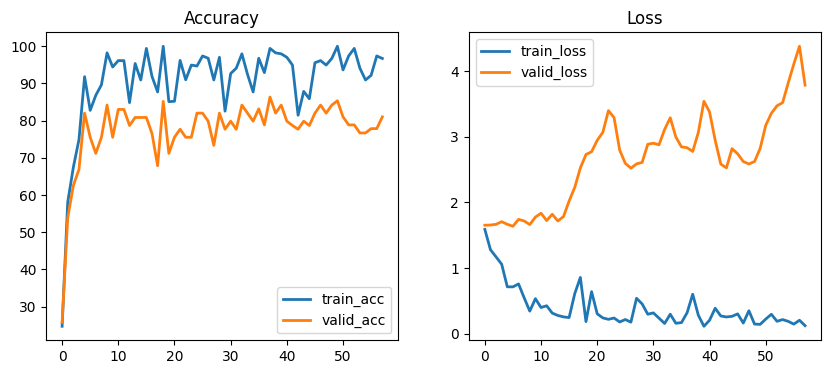

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,4))

axes[0].plot(np.arange(len(train_acc_list)),train_acc_list,label='train_acc',linewidth=2)
axes[0].plot(np.arange(len(valid_acc_list)),valid_acc_list,label='valid_acc',linewidth=2)
axes[0].set_title('Accuracy')
axes[0].legend(loc='best')

axes[1].plot(np.arange(len(train_loss_list)),train_loss_list,label='train_loss',linewidth=2)
axes[1].plot(np.arange(len(valid_loss_list)),valid_loss_list,label='valid_loss',linewidth=2)
axes[1].set_title('Loss')
axes[1].legend(loc='best')

# Predict

In [ ]:
resnet_50.load_state_dict(torch.load('./resnet50.pth')) # 학습한 모델 불러오기
resnet_50.eval()  # 평가 모드

class_names = ['Japan','Taiwan','Vietnam','Philippines','Thailand']

plt.figure(figsize=(20,20))
with torch.no_grad():
    for idx,(image,label) in enumerate(test_loader):
        image = image.to(device)

        outputs = resnet_50(image)
        _, preds = torch.max(outputs, 1)

        img = image.squeeze(0).permute(1,2,0).cpu().numpy()
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        img = (((img * std)+mean)*255).astype(int)

        plt.subplot(5,5,idx+1)
        plt.title(f'{label[0]} : {class_names[preds]}',fontsize=12)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()
    # plt.savefig('./resnet50_predict.jpg')
    plt.show()